In [1]:
import numpy as np
import matplotlib.pyplot as plt
from arc import *
import pickle
import scipy.optimize as opt
import scipy
from budget_monte_carlo import *

In [2]:
h = 6.626e-34
e = 1.602e-19
a0 = 5.291e-11
hbar = h/2/np.pi
EH = 4.359744e-18
c = 299792458
kb = 1.380649e-23
me = 9.1093837e-31
epi0 = 8.854e-12
bohr_r = 5.291e-11


<h2>Configuration</h2>

In [25]:
atom_name = 'Cs'
n=61
l = 1
j = 3/2
mj = 3/2

atom_d = 2.2 #um
Omega_Rabi= 10*2*np.pi  #MHz
Bz = 10 #G
pulse_time= 7.65 #Omega_Rabi
resolution = 100 # number of phase steps in the pulse
w0_rydberg = 50 #um
lambda_rydberg = 0.319 #um
HF_split = 500*np.pi*2 # MHz

T_atom = 5 #uK
trap_depth = 600 #uK
lambda_trap = 1.064 #um
w0_trap = 1.2 #um

edc_fluc = 1e-3 #V/cm
edc_zero = 0 #V/m

bdc_fluc = 1e-3 #G

num_samples =10000


In [26]:
if atom_name == "Rb":
    atom = Rubidium()
elif atom_name == "Cs":
    atom = Caesium()
blockade_mrad = find_blockade_Mrad(atom_name, n, atom_d)
print('Blockade:', blockade_mrad/2/np.pi , 'MHz')
R_lifetime = atom.getStateLifetime(n=n,l=l,j=j,temperature=300, includeLevelsUpTo=n+20,s=0.5)*1e6
m_atom = atom.mass

Blockade: 201.2720974670619 MHz


<h2>Find optimized phase</h2>

In [27]:
H_gen = Hamiltonians(Omega_Rabi1=Omega_Rabi, blockade_inf=False, blockade=blockade_mrad, r_lifetime=R_lifetime, Delta1=0, 
                         Stark1=0, Stark2=0, resolution=resolution, r_lifetime2=R_lifetime, pulse_time=pulse_time)
PhaseGuess = [2*np.pi*0.1122, 1.0431, -0.7318, 0]
time, phase_guess, dt = phase_cosine_generate(*PhaseGuess, H_gen.pulse_time,H_gen.resolution)
# fid_optimize(PhaseGuess, H_gen)
# H_gen.return_fidel
fid, global_phi = H_gen.return_fidel(phases=phase_guess, dt=dt)
print('Infidelity before optimizer:', 1-fid)
opt_out=opt.minimize(fun=fid_optimize,x0=PhaseGuess,args=(H_gen))
phase_params = opt_out.x
# print(phase_params)
infid_TO = opt_out.fun
print('Infidelity after optimizer:', infid_TO) 
print('phase parameter', phase_params)
##%%


Infidelity before optimizer: 0.002398095662580535
Infidelity after optimizer: 0.0003021643514894423
phase parameter [ 0.95579177  0.86233201 -1.41396907 -0.12296961]


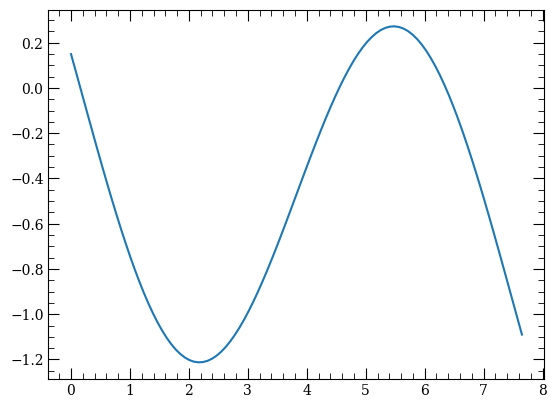

In [28]:
time, phase, dt = phase_cosine_generate(*phase_params, H_gen.pulse_time,H_gen.resolution)
fid, global_phi = H_gen.return_fidel(phases=phase, dt=dt)
plt.plot(time, phase)

<h2>Budget_calculation</h2>

In [29]:
doppler_shift = 1/lambda_trap/1e-6*np.sqrt(kb*(T_atom*1e-6)/m_atom)
print('doppler shift:', doppler_shift/2/np.pi, 'Hz')

calc = StarkMap(atom)
calc.defineBasis(n=n, l=1, j=1.5, mj=1.5, nMin=n-20, nMax=n+30, maxL=5, Bz=Bz/10000)
calc.diagonalise(np.linspace(0,60,600))
pol_dc = calc.getPolarizability(debugOutput=True)
edc_zero = 0
delta_edc = abs(-1/2*pol_dc*1e6*((edc_zero+edc_fluc)**2-edc_zero**2))*2*np.pi 
print('Electric DC fluctuation:', delta_edc/2/np.pi, 'Hz')

delta_bdc = atom.getZeemanEnergyShift(l=1, j=3/2, mj=3/2, magneticFieldBz=bdc_fluc/10000)/hbar
print('Magnetic DC fluctuation:', delta_bdc/2/np.pi, 'Hz')

total_shift = np.sqrt(delta_bdc**2+ delta_edc**2 + doppler_shift**2)
print('Total DC detuning fluctuation:', total_shift/2/np.pi, 'Hz')
detunings = total_shift/1e6/Omega_Rabi
print('delta/Ω:', detunings)
print('==============')
infids_s = []
for i in range(num_samples):
    d = sample_gaussian(detunings)
    H_gen = Hamiltonians(Omega_Rabi1=Omega_Rabi, blockade_inf=False, blockade=blockade_mrad, r_lifetime=R_lifetime, Delta1=d, 
                         Stark1=0, Stark2=0, resolution=resolution, r_lifetime2=R_lifetime, pulse_time=pulse_time)
    fid, global_phi = H_gen.return_fidel(phases=phase, dt=dt)
    infids_s.append(1-fid)
infids_s = np.asarray(infids_s)
infids_detuning = np.mean(infids_s)-infid_TO
infids_detiuning_std = infids_s.std(ddof=1)
print(f'total error due to detuning: {infids_detuning} +/- {infids_detiuning_std}')

infids_s = []
infids_blockade = []
infids_rabi = []
sigma_r = sigma_r_um(T_atom, trap_depth, w0_trap)
sigma_z = sigma_z_um(T_atom, trap_depth, w0_trap, lambda_trap)
ds, c1, c2, = sample_pair_distances(
        n_samples=num_samples,
        sigma_r=sigma_r,
        sigma_z=sigma_z,
        x_offset=atom_d,
        rng=None
)
x1 = c1['x']
y1 = c1['y']
z1 = c1['z']
x2 = c2['x']
y2 = c2['y']
z2 = c2['z']
rabi = np.sqrt(relative_gaussian_beam_intensity(0, 0, 0-atom_d/2, w0_rydberg, lambda_rydberg))
rabis1 = np.sqrt(relative_gaussian_beam_intensity(x1, z1, y1-atom_d/2, w0_rydberg, lambda_rydberg))/rabi
rabis2 = np.sqrt(relative_gaussian_beam_intensity(x2-atom_d, z2, y2+atom_d/2, w0_rydberg, lambda_rydberg))/rabi

for rabi1, rabi2, d in zip(rabis1, rabis2, ds):
    blockade = find_blockade_Mrad(atom_name, n, d)
    # total
    H_gen = Hamiltonians(Omega_Rabi1=Omega_Rabi, blockade_inf=False, blockade=blockade, r_lifetime=R_lifetime, Delta1=0, 
                     Stark1=0, Stark2=0, resolution=resolution, r_lifetime2=R_lifetime, pulse_time=pulse_time)
    fid, global_phi = H_gen.asym_return_fidel(phases=phase, dt=dt, omega1_scale=rabi1, omega2_scale=rabi2)
    infids_s.append(1-fid)

    H_gen_block = Hamiltonians(Omega_Rabi1=Omega_Rabi, blockade_inf=False, blockade=blockade, r_lifetime=R_lifetime, Delta1=0, 
                 Stark1=0, Stark2=0, resolution=resolution, r_lifetime2=R_lifetime, pulse_time=pulse_time)
    fid, global_phi = H_gen_block.asym_return_fidel(phases=phase, dt=dt, omega1_scale=1, omega2_scale=1)
    infids_blockade.append(1-fid)

    H_gen_rabi = Hamiltonians(Omega_Rabi1=Omega_Rabi, blockade_inf=False, blockade=blockade_mrad, r_lifetime=R_lifetime, Delta1=0, 
                 Stark1=0, Stark2=0, resolution=resolution, r_lifetime2=R_lifetime, pulse_time=pulse_time)
    fid, global_phi = H_gen_rabi.asym_return_fidel(phases=phase, dt=dt, omega1_scale=rabi1, omega2_scale=rabi2)
    infids_rabi.append(1-fid)
infids_s = np.asarray(infids_s)
infids_motion = np.mean(infids_s) - infid_TO
infids_motion_std = infids_s.std(ddof=1)

infids_blockade = np.asarray(infids_blockade)
infids_motion_blockade = np.mean(infids_blockade) - infid_TO
infids_motion_blockade_std = infids_blockade.std(ddof=1)

infids_rabi = np.asarray(infids_rabi)
infids_motion_rabi = np.mean(infids_rabi) - infid_TO
infids_motion_rabi_std = infids_rabi.std(ddof=1)

print(f'total error due to atom motion: {infids_motion} +/- {infids_motion_std}')
print(f'total error due to atom motion(blockade): {infids_motion_blockade} +/- {infids_motion_blockade_std}')
print(f'total error due to atom motion(rabi): {infids_motion_rabi} +/- {infids_motion_rabi_std}')

# delta_mj = atom.getZeemanEnergyShift(l=1, j=3/2, mj=3/2, magneticFieldBz=Bz/10000)/hbar/1e6 - \
# atom.getZeemanEnergyShift(l=1, j=3/2, mj=1/2, magneticFieldBz=Bz/10000)/hbar/1e6
leakage_mj  = (Omega_Rabi)**2/((Omega_Rabi)**2+HF_split**2)
print(f'eror due to leakage_mj:{leakage_mj}')

loss_decay = (2.95/(Omega_Rabi))/R_lifetime
print('error due to Rydberg decay:', loss_decay)

total_error = loss_decay + leakage_mj + infids_motion + infids_detuning
print('total error:', total_error)

doppler shift: 2645.5087349607716 Hz
finding original state for each electric field value
found  599
Scalar polarizability =  4188.607831408103  MHz cm^2 / V^2 
Electric DC fluctuation: 2094.3039157040516 Hz
Magnetic DC fluctuation: 2800.901714064941 Hz
Total DC detuning fluctuation: 4385.188225143704 Hz
delta/Ω: 0.00043851882251437035
total error due to detuning: 1.6546065066029916e-10 +/- 2.373383969691608e-10
total error due to atom motion: 0.00036773454903829604 +/- 0.0011532003943237603
total error due to atom motion(blockade): 0.00036742030867542043 +/- 0.0011528251442930707
total error due to atom motion(rabi): 1.5513235367744377e-08 +/- 2.2473074155194024e-08
eror due to leakage_mj:0.00039984006397441024
error due to Rydberg decay: 0.00029934540917359877
total error: 0.0010669201876469558


In [32]:
1/2*hbar*30e3*2*np.pi/kb

7.198788395892075e-07

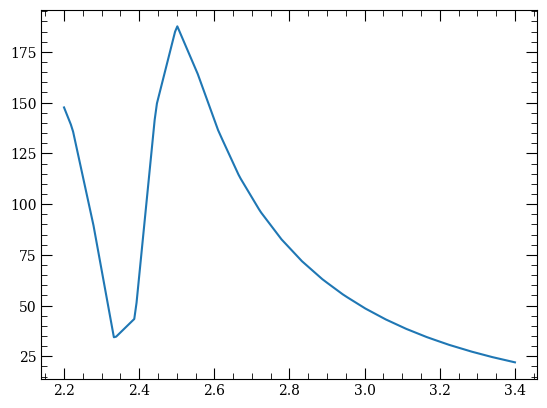

In [18]:
x = np.linspace(2.2, 3.4, 200)
blockade = [find_blockade_Mrad(atom_name, 65, y)/2/np.pi for y in x]
plt.plot(x,blockade)

(array([2.000e+01, 1.110e+02, 3.900e+02, 9.840e+02, 1.741e+03, 2.153e+03,
        1.966e+03, 1.386e+03, 6.650e+02, 3.290e+02, 1.430e+02, 5.900e+01,
        2.400e+01, 1.400e+01, 9.000e+00, 4.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([1.9927224 , 2.03365031, 2.07457821, 2.11550611, 2.15643401,
        2.19736192, 2.23828982, 2.27921772, 2.32014562, 2.36107353,
        2.40200143, 2.44292933, 2.48385723, 2.52478513, 2.56571304,
        2.60664094, 2.64756884, 2.68849674, 2.72942465, 2.77035255,
        2.81128045]),
 <BarContainer object of 20 artists>)

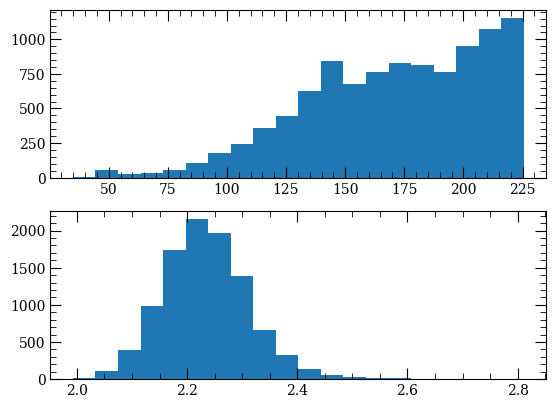

In [19]:
blockade = []
for rabi1, rabi2, d in zip(rabis1, rabis2, ds):
    blockade.append(find_blockade_Mrad(atom_name, n, d)/2/np.pi)
fig, ax = plt.subplots(nrows=2)
ax[0].hist(blockade, bins=20)
ax[1].hist(ds, bins=20)

<h2>Shot-to-shot detuning</h2>

In [81]:
deltas = np.linspace(0,0.1, 100)
deltas *= Omega_Rabi
infids_mean = []
infids_std  = []
for delta in deltas:
    infids_s = []
    for i in range(num_samples):
        d = sample_gaussian(delta)
        H_gen = Hamiltonians(Omega_Rabi1=Omega_Rabi, blockade_inf=False, blockade=blockade_mrad, r_lifetime=R_lifetime, Delta1=d, 
                             Stark1=0, Stark2=0, resolution=resolution, r_lifetime2=R_lifetime, pulse_time=pulse_time)
        fid, global_phi = H_gen.return_fidel(phases=phase, dt=dt)
        infids_s.append(1-fid)
    infids_s = np.asarray(infids_s)
    infids_mean.append(np.mean(infids_s))
    infids_std.append(infids_s.std(ddof=1))

KeyboardInterrupt: 

In [ ]:
infids_mean = np.asarray(infids_mean)
infids_std  = np.asarray(infids_std)
sem = infids_std / np.sqrt(num_samples)
fractional_delta = deltas/Omega_Rabi
fig, ax = plt.subplots()
ax.plot(fractional_delta, infids_mean, label="mean(1 - fid)")
ax.fill_between(
    fractional_delta,
    infids_mean - sem,
    infids_mean + sem,
    alpha=0.25,
    label="±1 std"
)
ax.set_xlabel(r"$\delta \Delta_{DC}/ \Omega $", fontsize=20)
ax.set_ylabel("$1 - \mathcal{F}$", fontsize=20)
# fig.show()
# ax.legend()

-0.0001570280038832724
0.9961896423700553


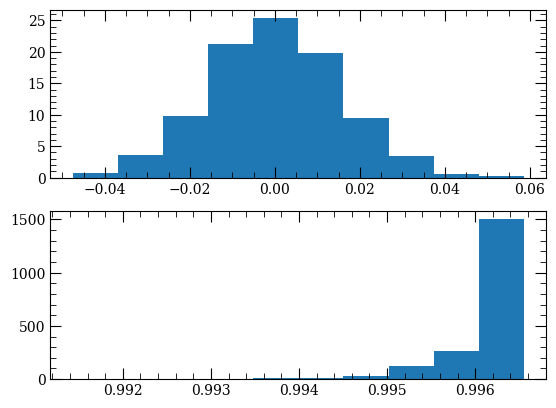

In [110]:
fig, ax = plt.subplots(nrows=2)

ax[0].hist(params, density=True)
ax[1].hist(infids, density= True)
print(np.mean(params))
print(np.mean(infids))

<h2>shot-to-shot Blockade</h2>

In [152]:
infids_mean = []
infids_std  = []
T_atoms = np.linspace(5,20,100)
for T_atom in T_atoms:
    infids_s = []
    sigma_r = sigma_r_um(T_atom, trap_depth, w0_trap)
    sigma_z = sigma_z_um(T_atom, trap_depth, w0_trap, lambda_trap)
    distances = sample_pair_distances(
            n_samples=num_samples,
            sigma_r=sigma_r,
            sigma_z=sigma_z,
            x_offset=atom_d,
            rng=None
    )[0]
    for d in distances:
        blockade = find_blockade_Mrad(atom_name, n, d)
        H_gen = Hamiltonians(Omega_Rabi1=Omega_Rabi, blockade_inf=False, blockade=blockade, r_lifetime=R_lifetime, Delta1=0, 
                             Stark1=0, Stark2=0, resolution=resolution, r_lifetime2=R_lifetime, pulse_time=pulse_time)
        fid, global_phi = H_gen.return_fidel(phases=phase, dt=dt)
        infids_s.append(1-fid)
    infids_s = np.asarray(infids_s)
    infids_mean.append(np.mean(infids_s))
    infids_std.append(infids_s.std(ddof=1))

Text(0, 0.5, '$1 - \\mathcal{F}$')

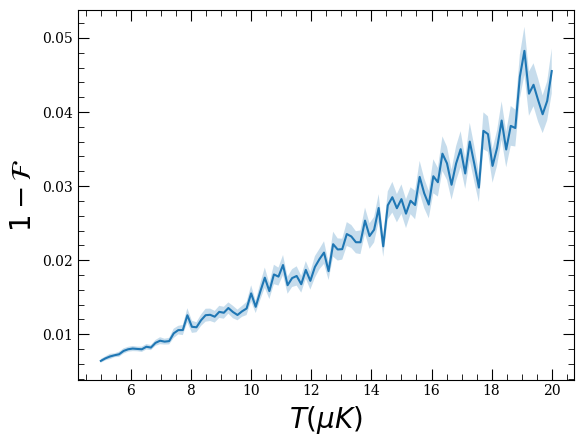

In [156]:
infids_mean = np.asarray(infids_mean)
infids_std  = np.asarray(infids_std)
sem = infids_std / np.sqrt(num_samples)
fig, ax = plt.subplots()
ax.plot(T_atoms, infids_mean, label="mean(1 - fid)")
ax.fill_between(
    T_atoms,
    infids_mean - sem,
    infids_mean + sem,
    alpha=0.25,
    label="±1 std"
)
ax.set_xlabel(r"$T(\mu K)$", fontsize=20)
ax.set_ylabel("$1 - \mathcal{F}$", fontsize=20)

<h2>shot-to-shot Intensity</h2>

In [49]:
infids_mean = []
infids_std  = []
T_atoms = np.linspace(5,20,100)
for T_atom in T_atoms:
    infids_s = []
    H_gen = Hamiltonians(Omega_Rabi1=Omega_Rabi, blockade_inf=False, blockade=blockade_mrad, r_lifetime=R_lifetime, Delta1=0, 
                             Stark1=0, Stark2=0, resolution=resolution, r_lifetime2=R_lifetime, pulse_time=pulse_time)
    sigma_r = sigma_r_um(T_atom, trap_depth, w0_trap)
    sigma_z = sigma_z_um(T_atom, trap_depth, w0_trap, lambda_trap)
    d, c1, c2, = sample_pair_distances(
            n_samples=num_samples,
            sigma_r=sigma_r,
            sigma_z=sigma_z,
            x_offset=atom_d,
            rng=None
    )
    x1 = c1['x']
    y1 = c1['y']
    z1 = c1['z']
    x2 = c2['x']
    y2 = c2['y']
    z2 = c2['z']
    rabi = np.sqrt(relative_gaussian_beam_intensity(0, 0, 0-atom_d/2, w0_rydberg, lambda_rydberg))
    rabis1 = np.sqrt(relative_gaussian_beam_intensity(x1, z1, y1-atom_d/2, w0_rydberg, lambda_rydberg))/rabi
    rabis2 = np.sqrt(relative_gaussian_beam_intensity(x2-atom_d, z2, y2+atom_d/2, w0_rydberg, lambda_rydberg))/rabi
    for rabi1, rabi2 in zip(rabis1, rabis2):
        fid, global_phi = H_gen.asym_return_fidel(phases=phase, dt=dt, omega1_scale=rabi1, omega2_scale=rabi2)
        infids_s.append(1-fid)
    infids_s = np.asarray(infids_s)
    infids_mean.append(np.mean(infids_s))
    infids_std.append(infids_s.std(ddof=1))

Text(0, 0.5, '$1 - \\mathcal{F}$')

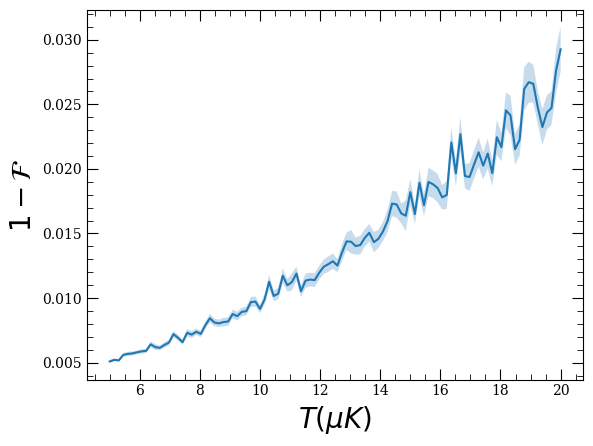

In [50]:
infids_mean = np.asarray(infids_mean)
infids_std  = np.asarray(infids_std)
sem = infids_std / np.sqrt(num_samples)
fig, ax = plt.subplots()
ax.plot(T_atoms, infids_mean, label="mean(1 - fid)")
ax.fill_between(
    T_atoms,
    infids_mean - sem,
    infids_mean + sem,
    alpha=0.25,
    label="±1 std"
)
ax.set_xlabel(r"$T(\mu K)$", fontsize=20)
ax.set_ylabel("$1 - \mathcal{F}$", fontsize=20)

In [159]:
delta_omegas = np.linspace(0,0.1, 100)
infids_mean = []
infids_std  = []
for delta_omega in delta_omegas:
    infids_s = []
    for i in range(num_samples):
        omega_scaled = sample_gaussian(delta_omega)
        H_gen = Hamiltonians(Omega_Rabi1=Omega_Rabi, blockade_inf=False, blockade=blockade_mrad, r_lifetime=R_lifetime, Delta1=0, 
                             Stark1=0, Stark2=0, resolution=resolution, r_lifetime2=R_lifetime, pulse_time=pulse_time)
        fid, global_phi = H_gen.return_fidel(phases=phase, dt=dt, omega_scale=(1-omega_scaled))
        infids_s.append(1-fid)
    infids_s = np.asarray(infids_s)
    infids_mean.append(np.mean(infids_s))
    infids_std.append(infids_s.std(ddof=1))

Text(0, 0.5, '$1 - \\mathcal{F}$')

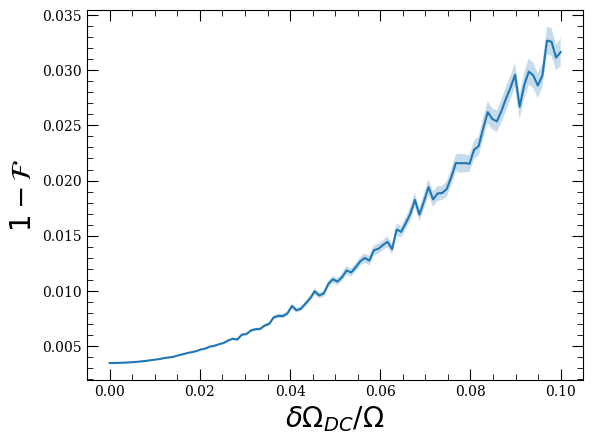

In [173]:
infids_mean = np.asarray(infids_mean)
infids_std  = np.asarray(infids_std)
sem = infids_std / np.sqrt(num_samples)
fig, ax = plt.subplots()
ax.plot(delta_omegas, infids_mean, label="mean(1 - fid)")
ax.fill_between(
    delta_omegas,
    infids_mean - sem,
    infids_mean + sem,
    alpha=0.25,
    label="±1 std"
)
ax.set_xlabel(r"$\delta \Omega_{DC}/ \Omega $", fontsize=20)
ax.set_ylabel("$1 - \mathcal{F}$", fontsize=20)

<h2>Atom motion</h2>

In [60]:
infids_mean = []
infids_std  = []
T_atoms = np.linspace(5,20,100)
for T_atom in T_atoms:
    infids_s = []

    sigma_r = sigma_r_um(T_atom, trap_depth, w0_trap)
    sigma_z = sigma_z_um(T_atom, trap_depth, w0_trap, lambda_trap)
    ds, c1, c2, = sample_pair_distances(
            n_samples=num_samples,
            sigma_r=sigma_r,
            sigma_z=sigma_z,
            x_offset=atom_d,
            rng=None
    )
    
    x1 = c1['x']
    y1 = c1['y']
    z1 = c1['z']
    x2 = c2['x']
    y2 = c2['y']
    z2 = c2['z']
    rabi = np.sqrt(relative_gaussian_beam_intensity(0, 0, 0-atom_d/2, w0_rydberg, lambda_rydberg))
    rabis1 = np.sqrt(relative_gaussian_beam_intensity(x1, z1, y1-atom_d/2, w0_rydberg, lambda_rydberg))/rabi
    rabis2 = np.sqrt(relative_gaussian_beam_intensity(x2-atom_d, z2, y2+atom_d/2, w0_rydberg, lambda_rydberg))/rabi
    for rabi1, rabi2, d in zip(rabis1, rabis2, ds):
        blockade = find_blockade_Mrad(atom_name, n, d)
        H_gen = Hamiltonians(Omega_Rabi1=Omega_Rabi, blockade_inf=False, blockade=blockade, r_lifetime=R_lifetime, Delta1=0, 
                         Stark1=0, Stark2=0, resolution=resolution, r_lifetime2=R_lifetime, pulse_time=pulse_time)
        fid, global_phi = H_gen.asym_return_fidel(phases=phase, dt=dt, omega1_scale=rabi1, omega2_scale=rabi2)
        infids_s.append(1-fid)
    infids_s = np.asarray(infids_s)
    infids_mean.append(np.mean(infids_s))
    infids_std.append(infids_s.std(ddof=1))

<h2>Read infdel</h2>

In [178]:
result = np.load('results/infid_raw.npz')

In [183]:
print(result['x_detuning'])

[0.         0.0010101  0.0020202  0.0030303  0.0040404  0.00505051
 0.00606061 0.00707071 0.00808081 0.00909091 0.01010101 0.01111111
 0.01212121 0.01313131 0.01414141 0.01515152 0.01616162 0.01717172
 0.01818182 0.01919192 0.02020202 0.02121212 0.02222222 0.02323232
 0.02424242 0.02525253 0.02626263 0.02727273 0.02828283 0.02929293
 0.03030303 0.03131313 0.03232323 0.03333333 0.03434343 0.03535354
 0.03636364 0.03737374 0.03838384 0.03939394 0.04040404 0.04141414
 0.04242424 0.04343434 0.04444444 0.04545455 0.04646465 0.04747475
 0.04848485 0.04949495 0.05050505 0.05151515 0.05252525 0.05353535
 0.05454545 0.05555556 0.05656566 0.05757576 0.05858586 0.05959596
 0.06060606 0.06161616 0.06262626 0.06363636 0.06464646 0.06565657
 0.06666667 0.06767677 0.06868687 0.06969697 0.07070707 0.07171717
 0.07272727 0.07373737 0.07474747 0.07575758 0.07676768 0.07777778
 0.07878788 0.07979798 0.08080808 0.08181818 0.08282828 0.08383838
 0.08484848 0.08585859 0.08686869 0.08787879 0.08888889 0.0898

<h2>Stark shift</h2>

In [65]:
inter_detuning = 5e3*2*np.pi #MHz
Omega1 = np.sqrt(Omega_Rabi*inter_detuning)
omega_photon1 = atom.getTransitionFrequency(n1=6, l1=0, j1=1/2, n2=7, l2=1, j2=1/2, s=0.5)
omega_photon1 += inter_detuning/2/np.pi
d_blue = atom.getDipoleMatrixElement(n1=6, l1=0, j1=1/2, mj1=-1/2, n2=7, l2=1, j2=1/2, mj2=1/2,q=1, s=0.5)*bohr_r/hbar*e
d_red = atom.getDipoleMatrixElement(n1=7, l1=1, j1=1/2, mj1=1/2, n2=n, l2=0, j2=1/2, mj2=-1/2,q=-1, s=0.5)*bohr_r/hbar*e
alpha_g_gen = DynamicPolarizability(atom, n=6, l=0, j=1/2, s=0.5)
alpha_g_gen.defineBasis(6, 9)
alpha_g = alpha_g_gen.getPolarizability(c/omega_photon1, units='SI', accountForStateLifetime=False, mj=None)

alpha_e_gen = DynamicPolarizability(atom, n=7, l=1, j=1/2, s=0.5)
alpha_e_gen.defineBasis(6, 9)
alpha_e = alpha_g_gen.getPolarizability(c/omega_photon1, units='SI', accountForStateLifetime=False, mj=None)

alpha_e_gen = DynamicPolarizability(atom, n=60, l=0, j=1/2, s=0.5)
alpha_e_gen.defineBasis(7, 75)
alpha_e = alpha_g_gen.getPolarizability(c/omega_photon1, units='SI', accountForStateLifetime=False, mj=None)

In [63]:
alpha_g

(np.float64(-414.8262903124463),
 np.float64(829.6525782720447),
 -0.0,
 3.892727808e-07,
 np.float64(1.2650666328922317e-06),
 [np.int64(7), 1, 0.5, 0.5])

In [72]:
atom.getEnergy(6, 0, 1/2)

np.float64(-3.8939057274321813)

AttributeError: 'Caesium' object has no attribute 'getIonisationEnergy'